## Computational ressources

## Librairies

In [26]:
import xarray as xr 
import dask 
import numpy as np 
import os 
import time 
import glob
from datetime import date
today=date.today()

import sys
sys.path.insert(0,'/home/albert7a/git/xscale')
import xscale

import xscale.spectral.fft as xfft
from xscale.spectral.tools import plot_spectrum
import xscale.signal.generator as xgen

import matplotlib.pyplot as plt
params = {'figure.figsize' : (15, 8),'legend.fontsize': 16,'xtick.labelsize':16,'ytick.labelsize':16,'axes.labelsize':16,'font.size':16}
plt.rcParams.update(params)


## Localisation of the point

In [27]:
data_dir = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-BLBT02-S/'
tfilename = sorted(glob.glob(data_dir+'*/eNATL60-BLBT02_1h_*_gridT-2D_20090701-20090701.nc'))
filename =tfilename[0]


In [28]:
%time ds=xr.open_dataset(filename)['sossheig']


CPU times: user 18.1 ms, sys: 12.6 ms, total: 30.7 ms
Wall time: 30.7 ms


In [29]:
ds

<xarray.DataArray 'sossheig' (time_counter: 24, y: 4729, x: 8354)>
[948145584 values with dtype=float32]
Coordinates:
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
    time_centered  (time_counter) datetime64[ns] ...
  * time_counter   (time_counter) datetime64[ns] 2009-07-01T00:30:00 ... 2009-07-01T23:30:00
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_surface_height_above_geoid
    long_name:           sea surface height
    units:               m
    online_operation:    average
    interval_operation:  40 s
    interval_write:      1 h
    cell_methods:        time: mean (interval: 40 s)

In [30]:
print(ds.nbytes/1e9)

3.792582336


CPU times: user 3.6 s, sys: 803 ms, total: 4.4 s
Wall time: 4.78 s


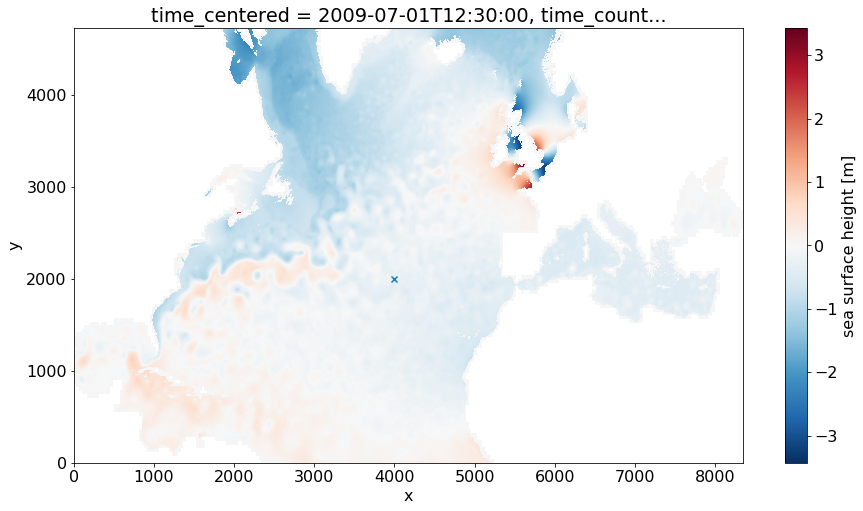

In [31]:
%%time 
ds[12].plot()
plt.scatter(4000,2000,marker='x')

## Importing the data : SSH in run eNATL60-BLBT02 for FMA months at location X

In [32]:
tfilenames_FMA = []

for month in ['02','03','04']:
    if month in ['12','01','02','03','04','05','06']:
        case='BLBT02X'
    else:
        case='BLBT02'

    if month in ['07','08','09','10','11','12']:
        year='2009'
    else:
        year='2010'
    
    data_dir = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-'+str(case)+'-S/'
    tfilenames_month = sorted(glob.glob(data_dir+'*/eNATL60-'+str(case)+'_1h_*_gridT-2D_'+str(year)+str(month)+'??-'+str(year)+str(month)+'??.nc'))
    tfilenames_FMA=tfilenames_FMA+tfilenames_month

In [33]:
%time dsFMA=xr.open_mfdataset(tfilenames_FMA)['sossheig'][:,2000,4000]
    

CPU times: user 1min 50s, sys: 26.4 s, total: 2min 16s
Wall time: 2min 49s


In [34]:
dsFMA

<xarray.DataArray 'sossheig' (time_counter: 2136)>
dask.array<shape=(2136,), dtype=float32, chunksize=(24,)>
Coordinates:
    nav_lat        float32 36.919193
    nav_lon        float32 -31.22679
    time_centered  (time_counter) datetime64[ns] dask.array<shape=(2136,), chunksize=(24,)>
  * time_counter   (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010-04-30T23:30:00
Attributes:
    standard_name:       sea_surface_height_above_geoid
    long_name:           sea surface height
    units:               m
    online_operation:    average
    interval_operation:  40 s
    interval_write:      1 h
    cell_methods:        time: mean (interval: 40 s)

In [35]:
print(dsFMA.nbytes/1e9)

8.544e-06


CPU times: user 3.55 s, sys: 720 ms, total: 4.27 s
Wall time: 9.7 s


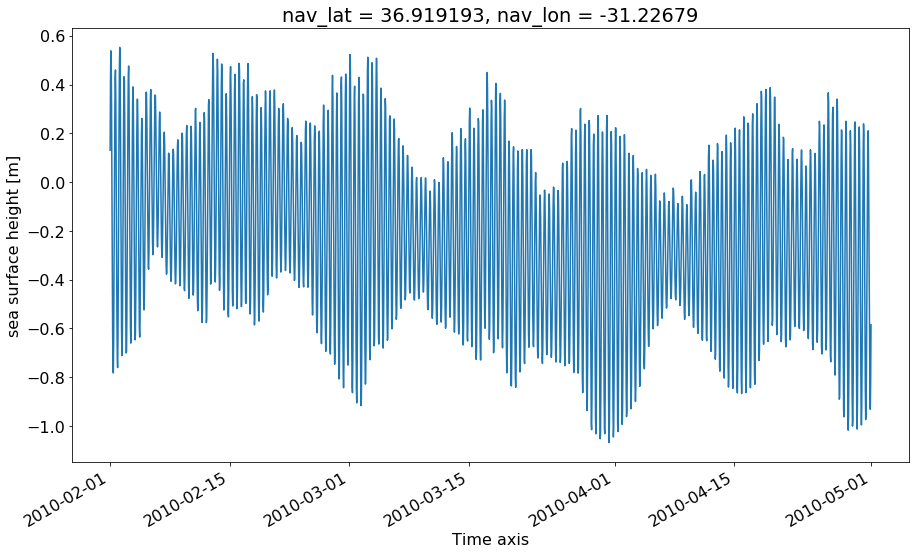

In [36]:
%time dsFMA.plot()

CPU times: user 6.81 s, sys: 848 ms, total: 7.66 s
Wall time: 7.74 s


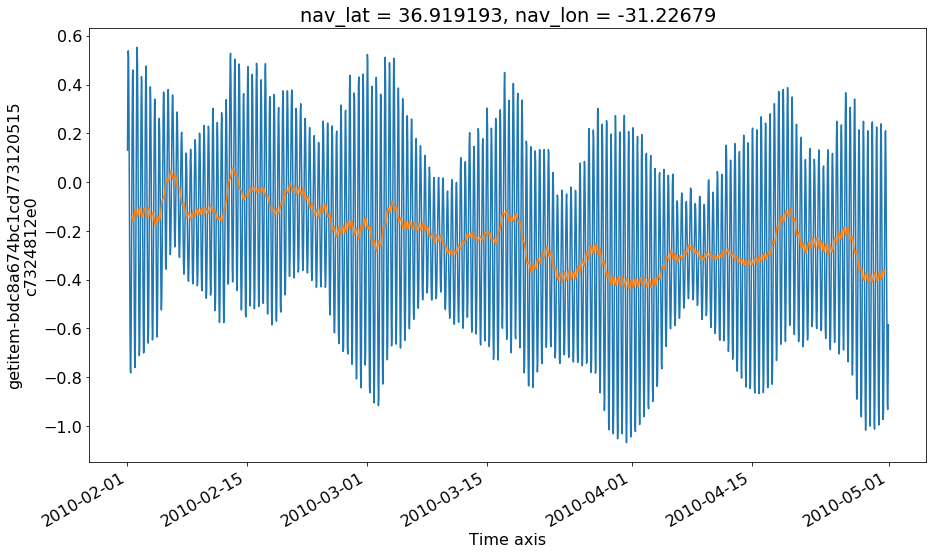

In [37]:
%%time 

dsFMA.plot(label='full data')
dsFMA.rolling(time_counter=24,center=True).mean().plot(label='rolling daily mean')

In [38]:
tfilenames_ASO = []

for month in ['08','09','10']:
    if month in ['12','01','02','03','04','05','06']:
        case='BLBT02X'
    else:
        case='BLBT02'

    if month in ['07','08','09','10','11','12']:
        year='2009'
    else:
        year='2010'
    
    data_dir = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-'+str(case)+'-S/'
    tfilenames_month = sorted(glob.glob(data_dir+'*/eNATL60-'+str(case)+'_1h_*_gridT-2D_'+str(year)+str(month)+'??-'+str(year)+str(month)+'??.nc'))
    tfilenames_ASO=tfilenames_ASO+tfilenames_month

In [39]:
%time dsASO=xr.open_mfdataset(tfilenames_ASO)['sossheig'][:,2000,4000]
    

CPU times: user 1min 54s, sys: 27.8 s, total: 2min 22s
Wall time: 2min 34s


## FFT decomposition and power spectral density computation

In [40]:
NPADDING = 2
SPtime_FMA = xfft.fft(dsFMA, dim='time_counter', dx=1., detrend='mean',nfft=dsFMA.shape[0]*NPADDING,tapering=True)
MEANPSD_FMA=xfft.psd(SPtime_FMA).load()
freqs_FMA=MEANPSD_FMA.f_time_counter.values
freqs_FMA = freqs_FMA[NPADDING::] 

SPtime_ASO = xfft.fft(dsASO, dim='time_counter', dx=1., detrend='mean',nfft=dsASO.shape[0]*NPADDING,tapering=True)
MEANPSD_ASO=xfft.psd(SPtime_ASO).load()
freqs_ASO=MEANPSD_ASO.f_time_counter.values
freqs_ASO = freqs_ASO[NPADDING::] 


Text(0.5, 1.0, 'Temporal Spectrum of SSH at the point')

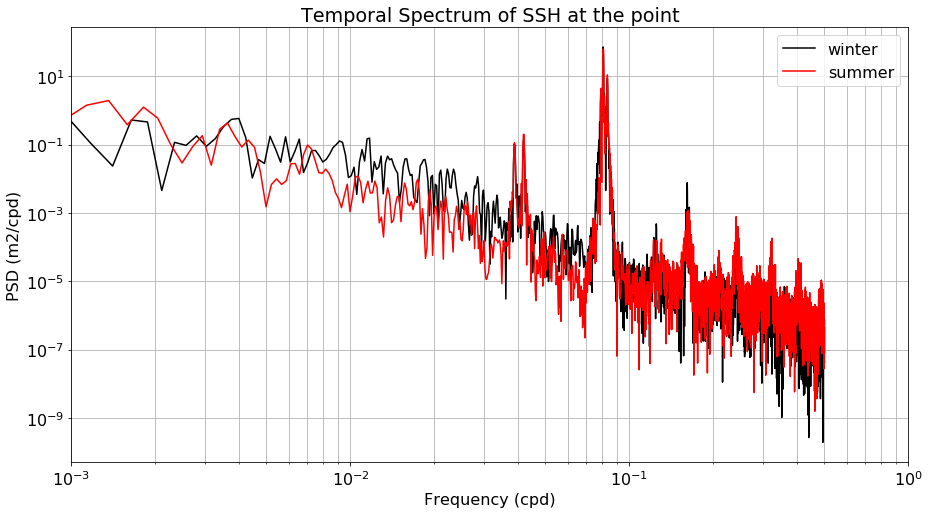

In [41]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)

ax.loglog(freqs_FMA,MEANPSD_FMA[NPADDING::],'k',label='winter')
ax.loglog(freqs_ASO,MEANPSD_ASO[NPADDING::],'r',label='summer')
ax.set_xlim(1e-3,1)
ax.grid(which='both',axis='both')
plt.xlabel('Frequency (cpd)')
plt.ylabel('PSD (m2/cpd)')
plt.legend()
plt.title('Temporal Spectrum of SSH at the point')